In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.transforms as transforms
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib notebook

In [2]:
#download data

url="https://covid19.isciii.es/resources/serie_historica_acumulados.csv"
df=pd.read_csv(url, encoding='latin_1', skipfooter=3, engine='python')

In [3]:
#change column names

df=df.rename(columns={'FECHA': 'Fecha', 'CASOS': "Casos"})

In [4]:
# create dataframe with population data (source: INE)

pop=pd.DataFrame({'Population':[8414240, 1319291, 1022800, 1149460, 2153389, 581078, 2399548, 2032863, 7675217, 5003769, 1067710, 2699499, 6663394, 1493898, 654214, 2207776, 316798, 84777, 86487], 'CCAA':['AN','AR','AS','IB','CN','CB','CL','CM','CT','VC','EX','GA','MD','MC','NC','PV','RI','CE','ML']})
pop=pop.set_index('CCAA')
pop['Population']=pop['Population'].astype('int32')

In [6]:
# data cleansing and preparation

df=df.fillna(0)
df['Fecha']=pd.to_datetime(df['Fecha'], format='%d/%m/%Y')
df[['Casos', 'Hospitalizados', 'UCI', 'Fallecidos', 'Recuperados']]=df[['Casos', 'Hospitalizados', 'UCI', 'Fallecidos', 'Recuperados']].astype('int32')
df=df.sort_values(['CCAA','Fecha'], ascending=[True, True])




In [7]:
# working with aggregated data for all of Spain and calculating incrementals

df_ESP=df.groupby('Fecha').agg({'Casos': sum, 'Fallecidos': sum, 'Recuperados': sum}).reset_index()
df_ESP['Activos']=df_ESP['Casos']-df_ESP['Fallecidos']-df_ESP['Recuperados']
df_ESP['CasosInc']=df_ESP['Casos'].diff()
df_ESP['CasosInc']=df_ESP['CasosInc'].fillna(0)
df_ESP['CasosInc']=df_ESP['CasosInc'].astype('int32')
df_ESP['CasosIncPct']=df_ESP['Casos'].pct_change()
df_ESP['CasosIncPct']=df_ESP['CasosIncPct'].fillna(0)
df_ESP['FallecidosInc']=df_ESP['Fallecidos'].diff()
df_ESP['FallecidosInc']=df_ESP['FallecidosInc'].fillna(0)
df_ESP['FallecidosInc']=df_ESP['FallecidosInc'].astype('int32')
df_ESP['FallecidosIncPct']=df_ESP['Fallecidos'].pct_change()
df_ESP['FallecidosIncPct']=df_ESP['FallecidosIncPct'].fillna(0)
df_ESP['ActivosInc']=df_ESP['Activos'].diff()
df_ESP['ActivosInc']=df_ESP['ActivosInc'].fillna(0)
df_ESP['ActivosInc']=df_ESP['ActivosInc'].astype('int32')
df_ESP['ActivosIncPct']=df_ESP['Activos'].pct_change()
df_ESP['ActivosIncPct']=df_ESP['ActivosIncPct'].fillna(0)
df_ESP=df_ESP.set_index('Fecha')
df_ESP=df_ESP.replace([np.inf, -np.inf], np.nan).fillna(0)

/Users/carmimar/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


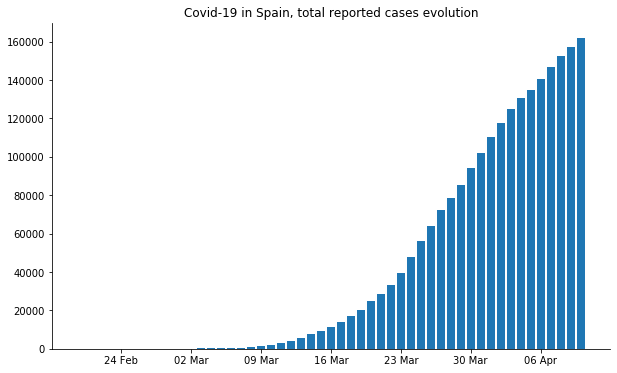

In [31]:
# plot total reported cases

plt.figure(figsize=(10,6))
plt.bar(df_ESP.index, df_ESP['Casos'])
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.title('Covid-19 in Spain, total reported cases evolution')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

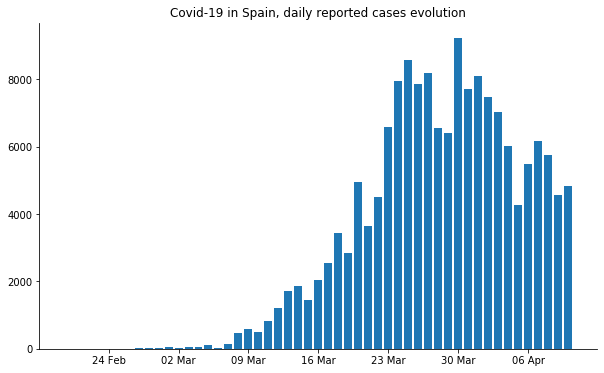

In [32]:
# plot incremental cases

plt.figure(figsize=(10,6))
plt.bar(df_ESP.index, df_ESP['CasosInc'])
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.title('Covid-19 in Spain, daily reported cases evolution')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

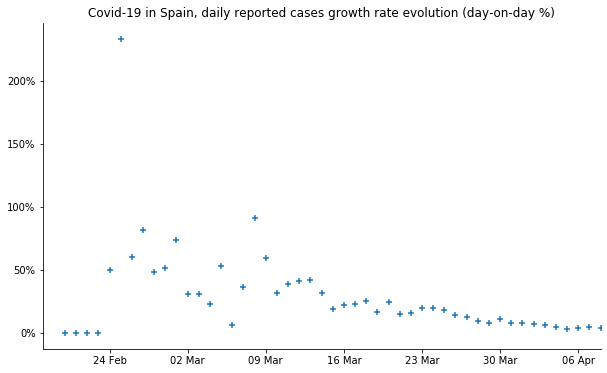

In [33]:
#plot incremental cases in %

plt.figure(figsize=(10,6))
plt.scatter(df_ESP.index, df_ESP['CasosIncPct'], marker='+')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.xlim('2020-02-18','2020-04-08')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.title('Covid-19 in Spain, daily reported cases growth rate evolution (day-on-day %)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

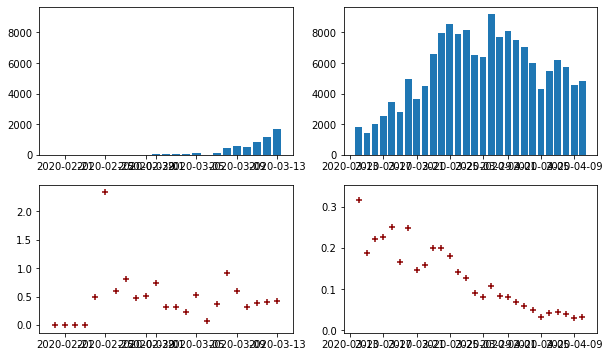

In [35]:
# let's see everything in the same figure

plt.figure(figsize=(10,6))
ax1 = plt.subplot(2, 2, 1)
plt.bar(df_ESP.index[0:23], df_ESP['CasosInc'][0:23])
# pass sharey=ax1 to ensure the two subplots share the same y axis
ax2 = plt.subplot(2, 2, 2, sharey=ax1)
plt.bar(df_ESP.index[23:], df_ESP['CasosInc'][23:])
ax3 = plt.subplot(2, 2, 3, sharex=ax1)
plt.scatter(df_ESP.index[0:23], df_ESP['CasosIncPct'][0:23], c='darkred', marker='+')
ax4 = plt.subplot(2, 2, 4, sharex=ax2)
plt.scatter(df_ESP.index[23:], df_ESP['CasosIncPct'][23:], c='darkred', marker='+')

In [36]:
# calculating regressions post 15th march

X=(df_ESP.index[25:]-df_ESP.index[0]).days.values.reshape(-1,1)
Y=df_ESP['CasosIncPct'][25:].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

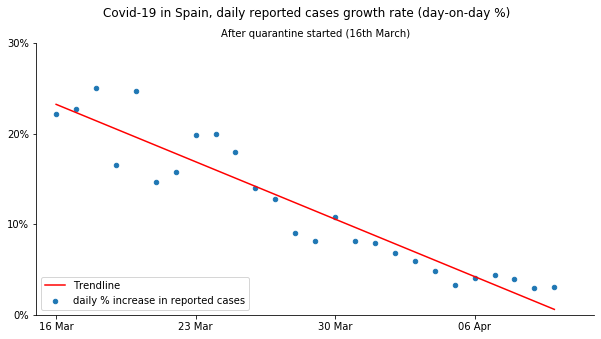

In [37]:
# plotting the scatter of incremental cases in % with the trendline

plt.figure(figsize=(10,5))
plt.plot(df_ESP.index[25:], Y_pred, c='red', label='Trendline')
plt.scatter(df_ESP.index[25:], Y, label='daily % increase in reported cases', s=20)
plt.suptitle('Covid-19 in Spain, daily reported cases growth rate (day-on-day %)', fontsize=12)
plt.title('After quarantine started (16th March)', fontsize=10)
plt.xlim('2020-03-15','2020-04-12')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylim(0, 0.3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc='lower left')

In [38]:
# print the trendline function and R2

linear_function= 'y = ' + str(linear_regressor.coef_[0,0])[:6] + 'x + ' + str(linear_regressor.intercept_[0])[:4]
print(linear_function)
print('R\u00b2 = ', '{:.{}f}'.format(r2_score(Y, Y_pred), 3))

y = -0.009x + 0.45
R² =  0.885


In [39]:
# trendline for pre-15 march period

X=(df_ESP.index[1:25]-df_ESP.index[0]).days.values.reshape(-1,1)
Y=df_ESP['CasosIncPct'][1:25].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

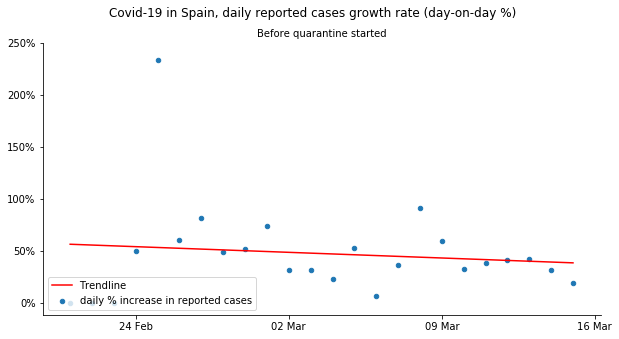

In [40]:
# plotting scatter with pre-15 march period

plt.figure(figsize=(10,5))
plt.plot(df_ESP.index[1:25], Y_pred, c='red', label='Trendline')
plt.scatter(df_ESP.index[1:25], Y, label='daily % increase in reported cases', s=20)
plt.suptitle('Covid-19 in Spain, daily reported cases growth rate (day-on-day %)', fontsize=12)
plt.title('Before quarantine started', fontsize=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.yticks(np.arange(0, 3, step=0.5))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc='lower left')

In [41]:
# print the trendline function and the R2

linear_function= 'y = ' + str(linear_regressor.coef_[0,0])[:6] + 'x + ' + str(linear_regressor.intercept_[0])[:4]
print(linear_function)
print('R\u00b2 = ', '{:.{}f}'.format(r2_score(Y, Y_pred), 3))

y = -0.007x + 0.56
R² =  0.014


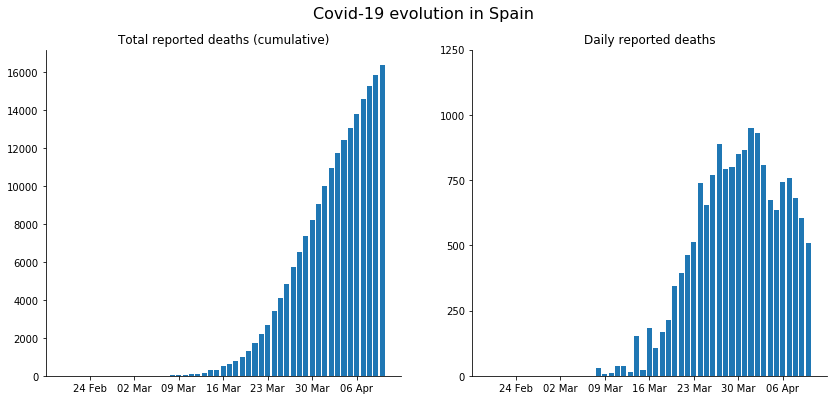

In [42]:
# plot evolution of deaths, total and incremental

plt.figure(figsize=(14,6))
plt.suptitle('Covid-19 evolution in Spain', fontsize=16)
ax1=plt.subplot(1,2,1)
ax1.bar(df_ESP.index, df_ESP['Fallecidos'])
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
ax1.set_title('Total reported deaths (cumulative)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2=plt.subplot(1,2,2)
ax2.bar(df_ESP.index, df_ESP['FallecidosInc'])
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
ax2.set_yticks(np.arange(0, 1500, 250))
ax2.set_title('Daily reported deaths')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

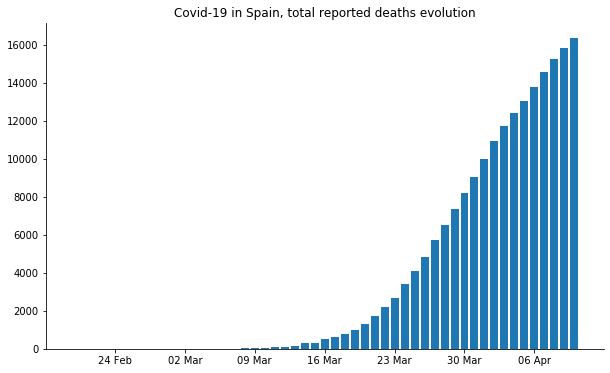

In [43]:
# plot cumulative deaths evolution

plt.figure(figsize=(10,6))
plt.bar(df_ESP.index, df_ESP['Fallecidos'])
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.title('Covid-19 in Spain, total reported deaths evolution')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

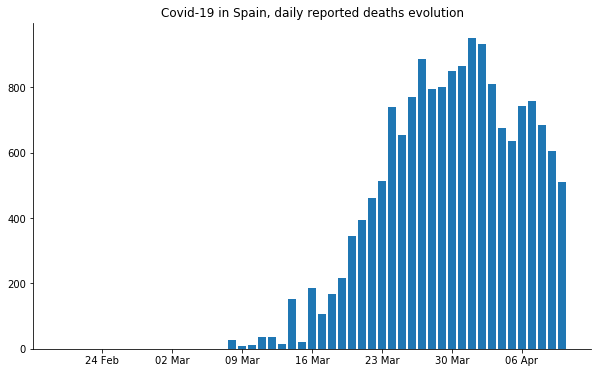

In [44]:
# plot incremental deaths

plt.figure(figsize=(10,6))
plt.bar(df_ESP.index, df_ESP['FallecidosInc'])
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.title('Covid-19 in Spain, daily reported deaths evolution')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

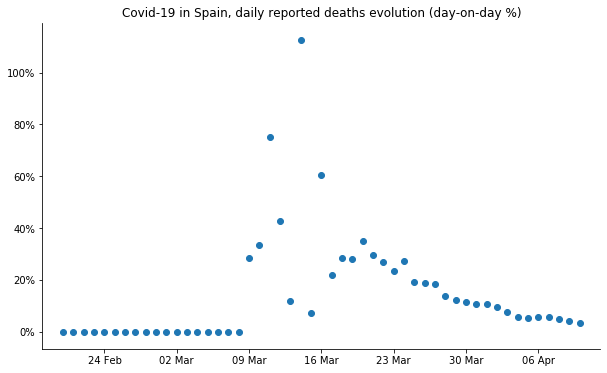

In [45]:
# plot scatter of incremental deaths in %

plt.figure(figsize=(10,6))
plt.scatter(df_ESP.index, df_ESP['FallecidosIncPct'])
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.title('Covid-19 in Spain, daily reported deaths evolution (day-on-day %)')
plt.xlim('2020-02-18','2020-04-12')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [47]:
# calculate trendlines for pre- and post-20 march

X1=(df_ESP.index[29:]-df_ESP.index[0]).days.values.reshape(-1,1)
Y1=df_ESP['FallecidosIncPct'][29:].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(X1, Y1)
Y1_pred = linear_regressor.predict(X1)

X2=(df_ESP.index[18:29]-df_ESP.index[0]).days.values.reshape(-1,1)
Y2=df_ESP['FallecidosIncPct'][18:29].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(X2, Y2)
Y2_pred = linear_regressor.predict(X2)

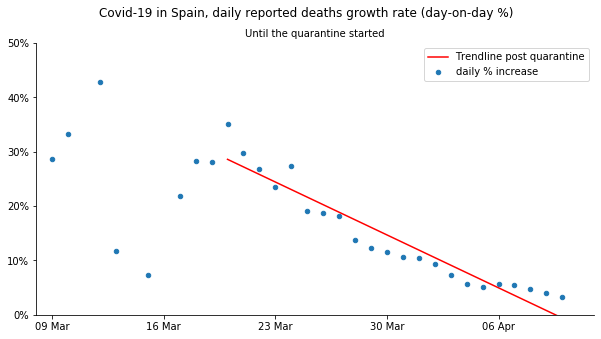

In [48]:
# plot scatter of incremental deaths including trendline

plt.figure(figsize=(10,5))
plt.scatter(df_ESP.index[18:], df_ESP['FallecidosIncPct'][18:], label='daily % increase', s=20)
plt.plot(df_ESP.index[29:], Y1_pred, c='red', label='Trendline post quarantine')
plt.suptitle('Covid-19 in Spain, daily reported deaths growth rate (day-on-day %)', fontsize=12)
plt.title('Until the quarantine started', fontsize=10)
plt.xlim('2020-03-08','2020-04-12')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylim(0, 0.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc='upper right')

In [49]:
# print trendline function and R2 

linear_function= 'y = ' + str(linear_regressor.coef_[0,0])[:6] + 'x + ' + str(linear_regressor.intercept_[0])[:4]
print(linear_function)
print('R\u00b2 = ', '{:.{}f}'.format(r2_score(Y1, Y1_pred), 3))

y = -0.013x + 0.72
R² =  0.910


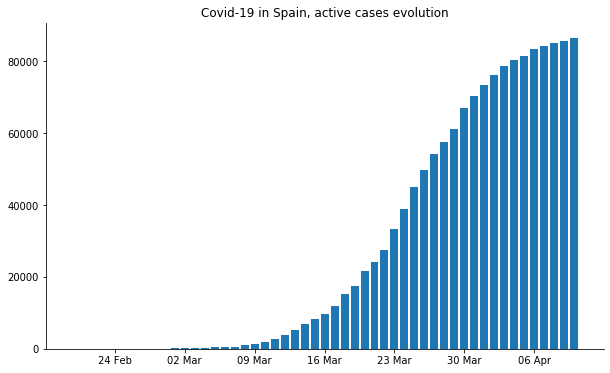

In [51]:
# plot evolution of active cases

plt.figure(figsize=(10,6))
plt.bar(df_ESP.index, df_ESP['Activos'])
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.title('Covid-19 in Spain, active cases evolution')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

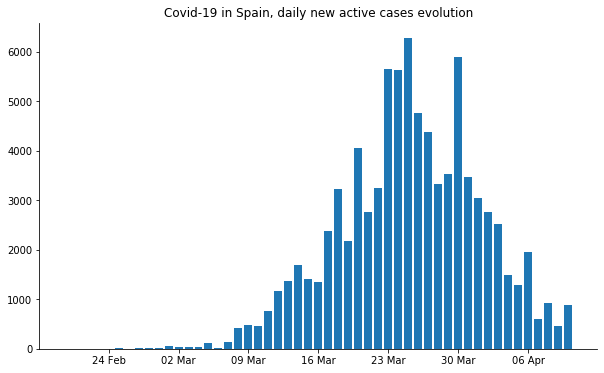

In [52]:
# plot incremental active cases

plt.figure(figsize=(10,6))
plt.bar(df_ESP.index, df_ESP['ActivosInc'])
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.title('Covid-19 in Spain, daily new active cases evolution')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

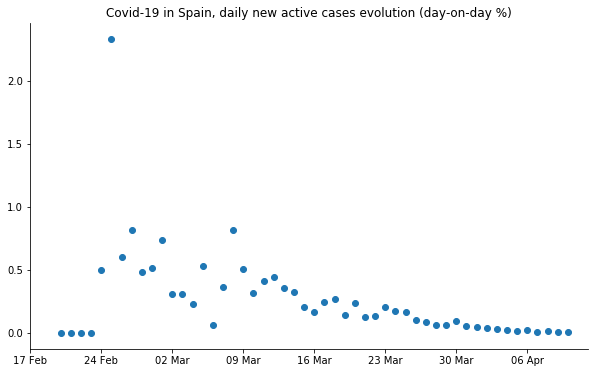

In [53]:
# plot scatter of incremental active cases in %

plt.figure(figsize=(10,6))
plt.scatter(df_ESP.index, df_ESP['ActivosIncPct'])
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.title('Covid-19 in Spain, daily new active cases evolution (day-on-day %)')
plt.xlim('2020-02-17', '2020-04-12')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [54]:
# trendline for post-15 march period for active cases

X=(df_ESP.index[25:]-df_ESP.index[0]).days.values.reshape(-1,1)
Y=df_ESP['ActivosIncPct'][25:].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

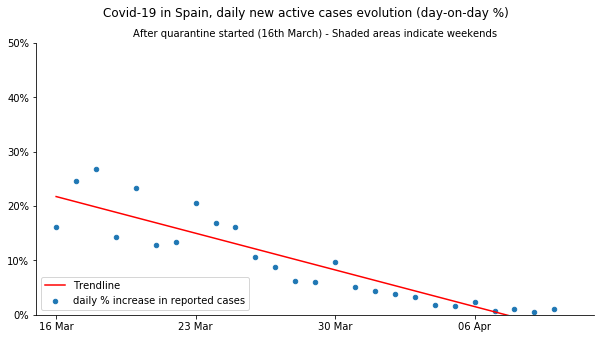

In [55]:
# plot scatter of incremental cases in % and trendline

plt.figure(figsize=(10,5))
plt.plot(df_ESP.index[25:], Y_pred, c='red', label='Trendline')
plt.scatter(df_ESP.index[25:], Y, label='daily % increase in reported cases', s=20)
plt.suptitle('Covid-19 in Spain, daily new active cases evolution (day-on-day %)', fontsize=12)
plt.title('After quarantine started (16th March) - Shaded areas indicate weekends', fontsize=10)
plt.xlim('2020-03-15','2020-04-12')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylim(0, 0.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc='lower left')

In [56]:
# print trendline function and R2

linear_function= 'y = ' + str(linear_regressor.coef_[0,0])[:6] + 'x + ' + str(linear_regressor.intercept_[0])[:4]
print(linear_function)
print('R\u00b2 = ', '{:.{}f}'.format(r2_score(Y, Y_pred), 3))

y = -0.009x + 0.45
R² =  0.826


In [57]:
# prepare data for regional analysis

pivot_df=df.pivot(index='CCAA', columns='Fecha', values='Casos')
pivot_df=pivot_df.sort_values(by='2020-03-15', ascending=False)
pivot_df.loc["Total"] = pivot_df.sum()

Text(18.6, 9300, '9149')

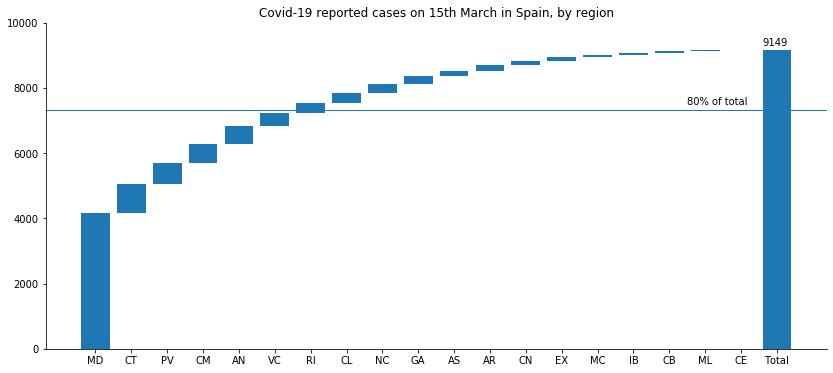

In [60]:
# plot regional situation at the beginning of the quarantine

basis=pivot_df['2020-03-15'].cumsum().shift(1, axis=0)
basis=basis.replace(np.nan,0).astype('int32')
basis[len(basis)-1]=0

# plotting it all out
plt.figure(figsize=(14,6))
plt.title('Covid-19 reported cases on 15th March in Spain, by region')

plt.bar(pivot_df.index, pivot_df['2020-03-15'], bottom=basis, color='tab:blue')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_ylim(0, 10000)
plt.gca().axhline(pivot_df.loc['Total','2020-03-15']*.8, lw=1)
plt.text(16.5,7500,'80% of total')
plt.text(18.6,9300,pivot_df.loc['Total','2020-03-15'])

In [121]:
# Calculate prevalence data

relative=pivot_df['2020-03-15']/pivot_df.loc['Total', '2020-03-15']
prevalence=pop.join(pivot_df['2020-03-15']).copy()
prevalence['prev']=(prevalence.iloc[:,-1]/prevalence['Population'])*1e6
prevalence.columns = ['pop', 'cases', 'prev']
prevalence=prevalence.sort_values(by='cases', ascending=False)

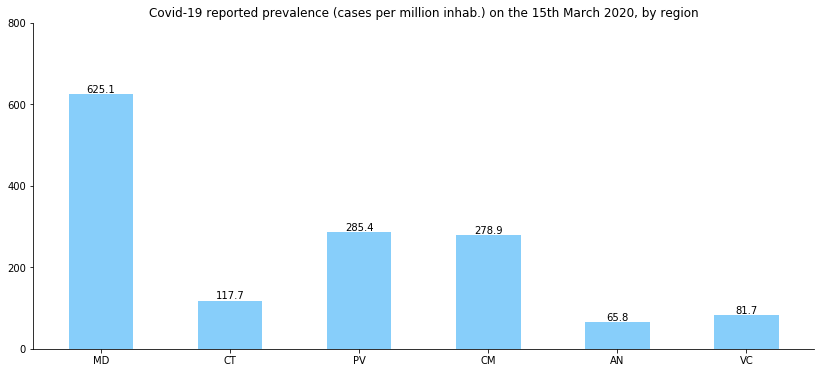

In [120]:
# prevalence at the beginning of the quarantine
plt.figure(figsize=(14,6))
p1=plt.bar(prevalence.index[:6], prevalence.prev[:6], color='lightskyblue', width=0.5)
plt.gca().set_yticks(np.arange(0, 1000, 200))
plt.gca().set_ylim(0, 800)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('Covid-19 reported prevalence (cases per million inhab.) on the 15th March 2020, by region')

for r1,i in zip(p1,prevalence.index[:6]):
    h1 = r1.get_height()
    plt.text(r1.get_x()+r1.get_width()/2., h1, "{:.1f}".format(prevalence.prev[i]), ha = 'center', va='bottom')

Text(0.5, 1.0, 'Covid-19 growth rates on the 15th March 2020, by region')

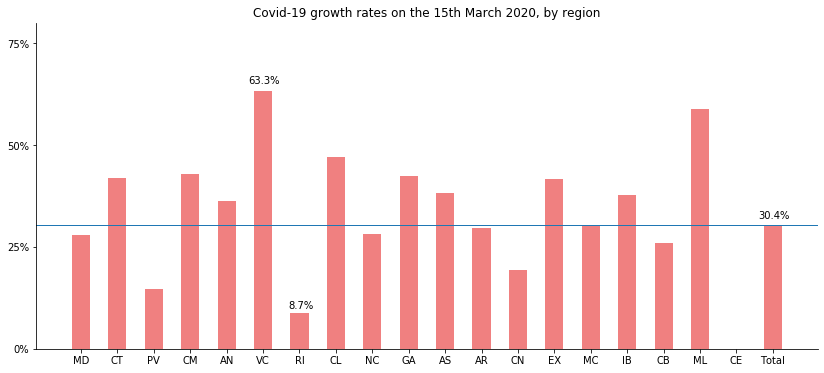

In [67]:
# plot daily growth per region at the beginning of the quarantine
growth=(pivot_df['2020-03-15']/pivot_df['2020-03-12'])**(1/3)-1
growth=growth.replace(np.inf, 0)

plt.figure(figsize=(14,6))
plt.bar(growth.index, growth.values, color='lightcoral', width=0.5)
plt.gca().axhline(growth[-1], lw=1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().set_yticks(np.arange(0, 1, 0.25))
plt.gca().set_ylim(0, 0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.text(18.6,.32,"{:.1f}%".format(growth[-1]*100))
plt.text(4.6, .65, "{:.1f}%".format(growth[5]*100))
plt.text(5.7, .1, "{:.1f}%".format(growth[6]*100))
plt.title('Covid-19 growth rates on the 15th March 2020, by region')

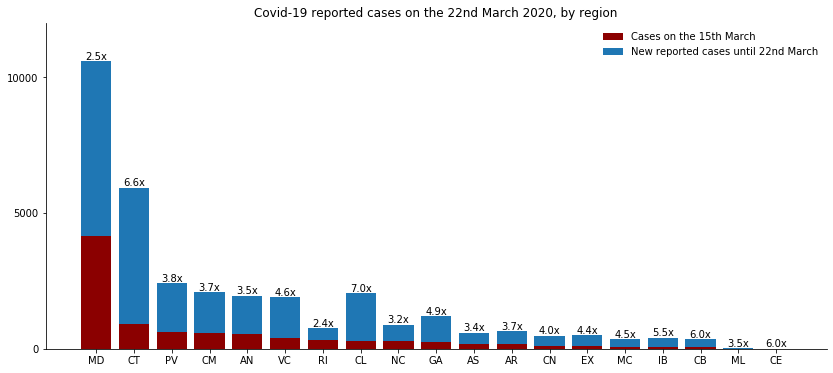

In [123]:
# plot the regional situation after 1 week of quarantine
basis=pivot_df['2020-03-22'].cumsum().shift(1, axis=0)
basis=basis.replace(np.nan,0).astype('int32')
basis[len(basis)-1]=0
previous=pivot_df['2020-03-15']
current=pivot_df['2020-03-22']-previous
multiple=pivot_df['2020-03-22']/pivot_df['2020-03-15']

# exponential growth per region at the beginning of the quarantine
growth=(pivot_df['2020-03-22']/pivot_df['2020-03-19'])**(1/3)-1
growth=growth.replace(np.inf, 0)

# plotting it all out
plt.figure(figsize=(14,6))
p1= plt.bar(pivot_df.index[:-1], previous[:-1], color='darkred', label='Cases on the 15th March')
p2= plt.bar(pivot_df.index[:-1], current[:-1], bottom=previous[:-1], label='New reported cases until 22nd March')
plt.yticks(np.arange(0, 100000, 5000))
plt.ylim(0, 12000)
plt.title('Covid-19 reported cases on the 22nd March 2020, by region')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper right', frameon=False)
for r1,r2,i in zip(p1,p2,multiple.index):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x()+r1.get_width()/2., h1+h2, "{:.1f}x".format(multiple[i]), ha = 'center', va='bottom')

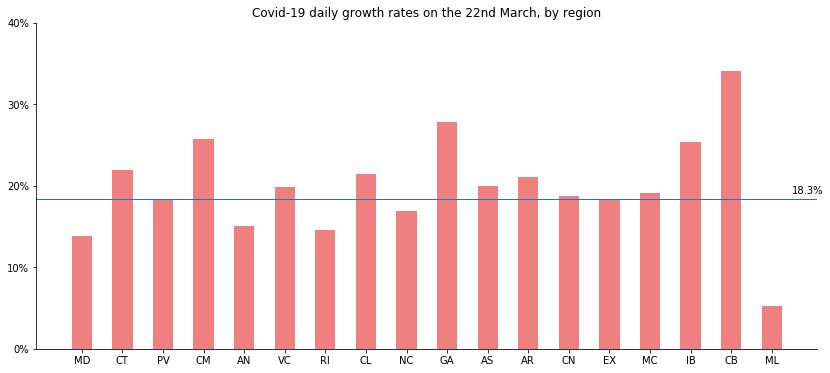

In [71]:
# plot daily growth rates after 1 week of quarantine

plt.figure(figsize=(14,6))
plt.bar(growth.index[:-2], growth.values[:-2], color='lightcoral', width=0.5)
plt.axhline(growth[-1], lw=1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylim(0, 0.4)
plt.text(17.5,.19,"{:.1f}%".format(growth[-1]*100))
plt.title('Covid-19 daily growth rates on the 22nd March, by region')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Text(0.5, 1.0, 'Daily growth rate by region')

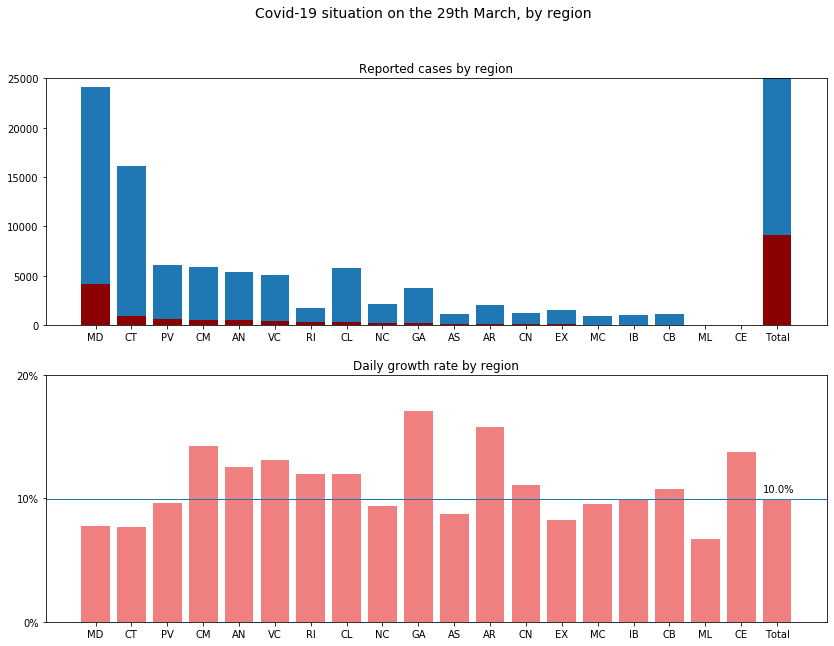

In [124]:
# regional situation after 2nd week of quarantine
basis=pivot_df['2020-03-29'].cumsum().shift(1, axis=0)
basis=basis.replace(np.nan,0).astype('int32')
basis[len(basis)-1]=0
previous=pivot_df['2020-03-15']
current=pivot_df['2020-03-29']-previous

# exponential growth per region at the beginning of the quarantine
growth=(pivot_df['2020-03-29']/pivot_df['2020-03-26'])**(1/3)-1
growth=growth.replace(np.inf, 0)

# plotting it all out
fig, ax1 = plt.subplots(2,1,figsize=(14,10))
fig.suptitle('Covid-19 situation on the 29th March, by region', fontsize=14)
ax1=plt.subplot(2,1,1)
ax1.bar(pivot_df.index, previous, color='darkred')
ax1.bar(pivot_df.index, current, bottom=previous)
ax1.set_yticks(np.arange(0, 100000, 5000))
ax1.set_ylim(0, 25000)
ax1.set_title('Reported cases by region')
ax2=plt.subplot(2,1,2)
ax2.bar(growth.index, growth.values, color='lightcoral')
ax2.axhline(growth[-1], lw=1)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.set_ylim(0, 0.2)
ax2.text(18.6,.105,"{:.1f}%".format(growth[-1]*100))
ax2.set_title('Daily growth rate by region')

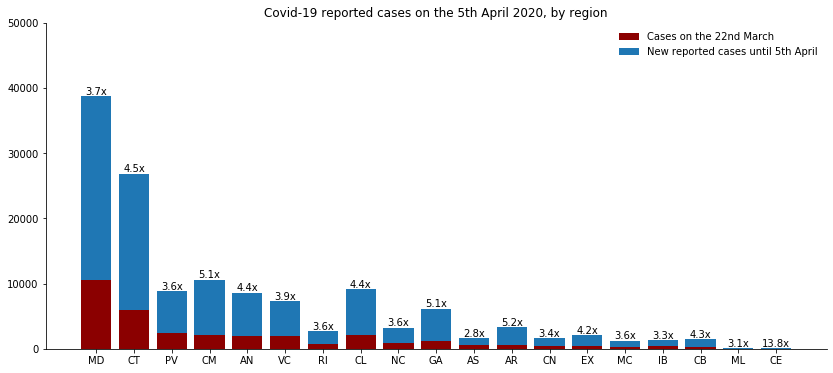

In [73]:
# regional situation after 3 weeks of quarantine
basis=pivot_df['2020-04-05'].cumsum().shift(1, axis=0)
basis=basis.replace(np.nan,0).astype('int32')
basis[len(basis)-1]=0
previous=pivot_df['2020-03-22']
current=pivot_df['2020-04-05']-previous
multiple=pivot_df['2020-04-05']/pivot_df['2020-03-22']

# exponential growth per region at the beginning of the quarantine
growth=(pivot_df['2020-04-05']/pivot_df['2020-04-02'])**(1/3)-1
growth=growth.replace(np.inf, 0)

# plotting it all out
plt.figure(figsize=(14,6))
p1= plt.bar(pivot_df.index[:-1], previous[:-1], color='darkred', label='Cases on the 22nd March')
p2= plt.bar(pivot_df.index[:-1], current[:-1], bottom=previous[:-1], label='New reported cases until 5th April')
plt.yticks(np.arange(0, 100000, 10000))
plt.ylim(0, 50000)
plt.title('Covid-19 reported cases on the 5th April 2020, by region')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper right', frameon=False)
for r1,r2,i in zip(p1,p2,multiple.index):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x()+r1.get_width()/2., h1+h2, "{:.1f}x".format(multiple[i]), ha = 'center', va='bottom')

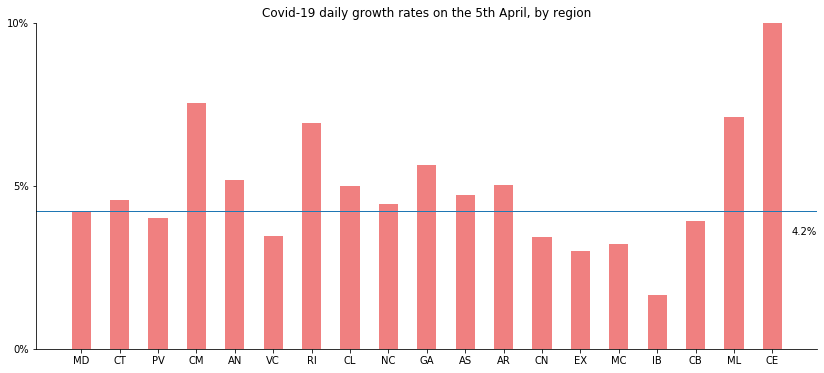

In [74]:
# plot daily growth after 3 weeks of quarantine

plt.figure(figsize=(14,6))
plt.bar(growth.index[:-1], growth.values[:-1], color='lightcoral', width=0.5)
plt.axhline(growth[-0], lw=1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.yticks(np.arange(0, 1, 0.05))
plt.ylim(0, 0.1)
plt.text(18.5,.035,"{:.1f}%".format(growth[-0]*100))
plt.title('Covid-19 daily growth rates on the 5th April, by region')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

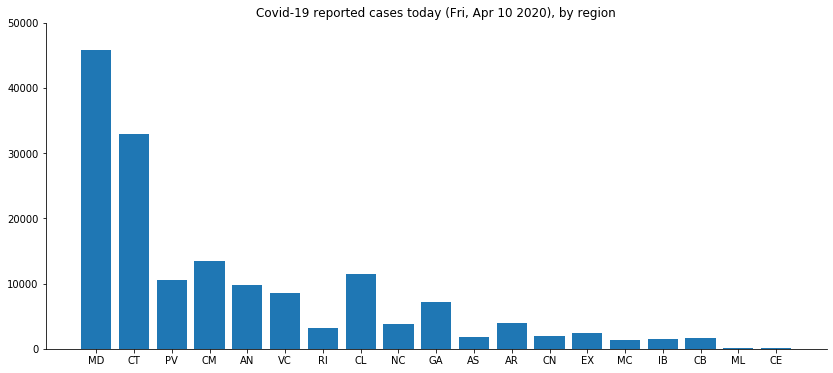

In [77]:
# plot regional situation today
basis=pivot_df[pivot_df.columns[-1]].cumsum().shift(1, axis=0)
basis=basis.replace(np.nan,0).astype('int32')
basis[-1]=0
multiple=pivot_df[pivot_df.columns[-1]]/pivot_df['2020-04-05']

# exponential growth per region today
growth=(pivot_df[pivot_df.columns[-1]]/pivot_df[pivot_df.columns[-4]])**(1/3)-1
growth=growth.replace(np.inf, 0)

# plotting it all out
plt.figure(figsize=(14,6))
p2= plt.bar(pivot_df.index[:-1], pivot_df[pivot_df.columns[-1]][:-1])
plt.yticks(np.arange(0, 100000, 10000))
plt.ylim(0, 50000)
plt.title('Covid-19 reported cases today ({0:%a, %b %d %Y}), by region'.format(pivot_df.columns[-1]))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

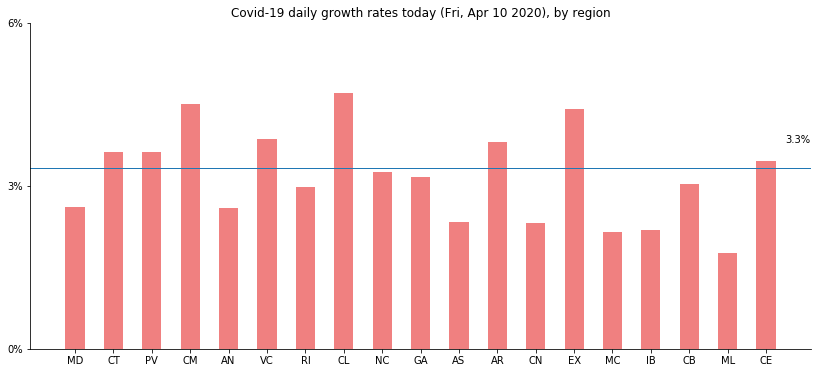

In [79]:
# plot growth rates today

plt.figure(figsize=(14,6))
plt.bar(growth.index[:-1], growth.values[:-1], color='lightcoral', width=0.5)
plt.axhline(growth[-1], lw=1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.yticks(np.arange(0, 1, 0.03))
plt.ylim(0, 0.06)
plt.text(18.5,.038,"{:.1f}%".format(growth[-1]*100))
plt.title('Covid-19 daily growth rates today ({0:%a, %b %d %Y}), by region'.format(pivot_df.columns[-1]))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [109]:
# prepare data for bubble chart

newdf=pivot_df.iloc[:, -1:].copy()
newdf=newdf.join(pop)
newdf.columns=['Cases', 'Pop']
newdf.iloc[-1,-1]=newdf['Pop'].sum()
newdf=newdf.astype('int32').copy()
newdf=newdf.join(growth.rename('Growth'))
newdf['Prev']=newdf['Cases']/newdf['Pop']*1000

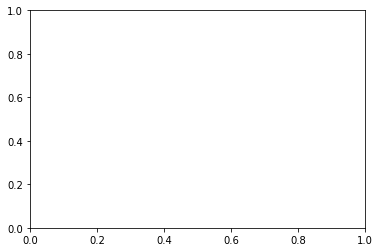

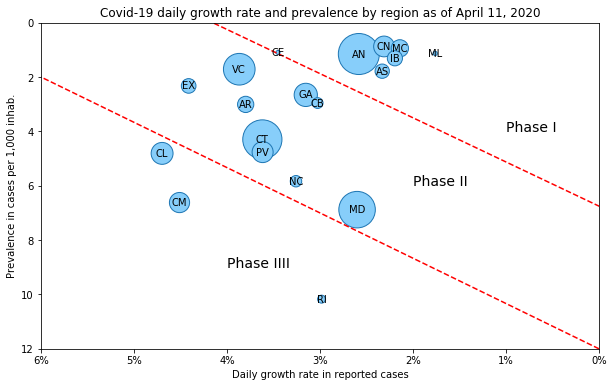

In [117]:
# plot bubble charts

f, ax = plt.subplots(1,1)
plt.figure(figsize=(10,6))
plt.scatter(newdf['Growth'][:-1], newdf['Prev'][:-1], s=newdf['Pop'][:-1]/5000, edgecolor='tab:blue', color='lightskyblue')
plt.gca().set_ylim(12,0)
plt.gca().set_xlim(0.06,0)
plt.gca().set_ylabel('Prevalence in cases per 1,000 inhab.')
plt.gca().set_xlabel('Daily growth rate in reported cases')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.plot([-0.02,0.06],[10,-3],'r--')
plt.plot([0,0.06],[12,2],'r--')
plt.title('Covid-19 daily growth rate and prevalence by region as of April 11, 2020')
plt.text(0.01, 4, 'Phase I', fontsize=14)
plt.text(0.02, 6, 'Phase II', fontsize=14)
plt.text(0.04, 9, 'Phase IIII', fontsize=14)

# include labels for each bubble

for i,txt in enumerate(newdf.index[:-1]):
    dx, dy = 0, np.sqrt(newdf.Pop[i])/f.dpi + 3/f.dpi
    offset = transforms.ScaledTranslation(dx, dy, f.dpi_scale_trans)
    transform=ax.transData+offset, 
    plt.text(newdf['Growth'][i], newdf['Prev'][i], newdf.index[i], va='center', ha='center', color='black', fontsize=10)